In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GilangW\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GilangW\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [2]:
df_ori = pd.read_csv('twitter_training.csv')#, index_col=0)
df_val = pd.read_csv('twitter_validation.csv')#, index_col=0)

In [3]:
df = df_ori.copy()

In [4]:
df.columns = ['id','entity','sentiment','tweet_content']
df.head()

,id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             74681 non-null  int64 
 1   entity         74681 non-null  object
 2   sentiment      74681 non-null  object
 3   tweet_content  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
df['tweet_content'] = df['tweet_content'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             74681 non-null  int64 
 1   entity         74681 non-null  object
 2   sentiment      74681 non-null  object
 3   tweet_content  74681 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
df.columns

Index(['id', 'entity', 'sentiment', 'tweet_content'], dtype='object')

In [8]:
# df.rename(columns=lambda x: x.strip().replace(' ', '').lower(), inplace=True)
df = df.rename(columns=lambda x: x.strip())

In [9]:
df.columns

Index(['id', 'entity', 'sentiment', 'tweet_content'], dtype='object')

In [10]:
df.nunique()

id               12447
entity              32
sentiment            4
tweet_content    69491
dtype: int64

In [11]:
print(df['entity'].unique())
print(df['sentiment'].unique())

['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']
['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [12]:
df_val.columns = ['id','entity','sentiment','tweet_content']
df_val.head()

,id,entity,sentiment,tweet_content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [13]:
print(df_val['entity'].unique())
print(df_val['sentiment'].unique())

['Amazon' 'Microsoft' 'CS-GO' 'Google' 'FIFA' 'MaddenNFL'
 'TomClancysRainbowSix' 'AssassinsCreed' 'CallOfDuty' 'Dota2' 'Verizon'
 'NBA2K' 'Nvidia' 'GrandTheftAuto(GTA)' 'RedDeadRedemption(RDR)'
 'Hearthstone' 'ApexLegends' 'Overwatch'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Borderlands' 'PlayStation5(PS5)'
 'johnson&johnson' 'Fortnite' 'Xbox(Xseries)' 'CallOfDutyBlackopsColdWar'
 'Facebook' 'HomeDepot' 'Cyberpunk2077' 'TomClancysGhostRecon'
 'WorldOfCraft' 'LeagueOfLegends' 'Battlefield']
['Neutral' 'Negative' 'Positive' 'Irrelevant']


In [14]:
# INDONESIAN STOPWORDS
# stopwords_nltk = nltk.corpus.stopwords
from nltk.corpus import stopwords
stpwds_id = list(set(stopwords.words('indonesian')))
stpwds_id.append('oh')
print(stpwds_id[:5])

# Define Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer_id = StemmerFactory().create_stemmer()

['hingga', 'agak', 'mengenai', 'pertanyaan', 'ditandaskan']


In [15]:
# ENGLISH STOPWORDS
# stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords.words('english')
print(stop_words[:5])

# Define Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

['i', 'me', 'my', 'myself', 'we']


In [16]:
# Create A Function for Text Preprocessing
def text_preprocessing(text):
  # # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stop_words]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [17]:
# Applying Text Preprocessing to the Dataset

df['text_processed'] = df['tweet_content'].apply(lambda x: text_preprocessing(x))
df

,id,entity,sentiment,tweet_content,text_processed
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im get borderland murder
...,...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realiz window partit mac like year behind nvid...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realiz mac window partit year behind nvidia dr...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realiz window partit mac year behind nvidia dr...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...,realiz window partit mac like year behind nvid...


In [19]:
# Display Target
df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [20]:
# Change Target into Number
df['label'] = df['sentiment'].replace({'Negative' : 0, 'Neutral' : 1, 'Positive' : 2, 'Irrelevant' : 3})
df

,id,entity,sentiment,tweet_content,text_processed,label
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill,2
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill,2
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder,2
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder,2
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im get borderland murder,2
...,...,...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realiz window partit mac like year behind nvid...,2
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realiz mac window partit year behind nvidia dr...,2
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realiz window partit mac year behind nvidia dr...,2
74679,9200,Nvidia,Positive,Just realized between the windows partition of...,realiz window partit mac like year behind nvid...,2


In [35]:
df[df['sentiment'] == 'Negative'].head()

,id,entity,sentiment,tweet_content,text_processed,label
23,2405,Borderlands,Negative,the biggest dissappoinment in my life came out...,biggest dissappoin life came year ago fuck bor...,0
24,2405,Borderlands,Negative,The biggest disappointment of my life came a y...,biggest disappoint life came year ago,0
25,2405,Borderlands,Negative,The biggest disappointment of my life came a y...,biggest disappoint life came year ago,0
26,2405,Borderlands,Negative,the biggest dissappoinment in my life coming o...,biggest dissappoin life come year ago fuck bor...,0
27,2405,Borderlands,Negative,For the biggest male dissappoinment in my life...,biggest male dissappoin life came hang year ti...,0


In [36]:
df[df['sentiment'] == 'Neutral'].head()

,id,entity,sentiment,tweet_content,text_processed,label
11,2403,Borderlands,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",rock hard la varlop rare power handsom jackpot...,1
12,2403,Borderlands,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",rock hard la varlop rare power handsom jackpot...,1
13,2403,Borderlands,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",rock hard la varlop rare power handsom jackpot...,1
14,2403,Borderlands,Neutral,"Rock-Hard La Vita, RARE BUT POWERFUL, HANDSOME...",rock hard la vita rare power handsom jackpot b...,1
15,2403,Borderlands,Neutral,"Live Rock - Hard music La la Varlope, RARE & t...",live rock hard music la la varlop rare power l...,1


In [37]:
df[df['sentiment'] == 'Irrelevant'].head()

,id,entity,sentiment,tweet_content,text_processed,label
101,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela landa p...,3
102,2418,Borderlands,Irrelevant,Appreciate the (sound) concepts / practices th...,appreci sound concept practic valenzuela landa...,3
103,2418,Borderlands,Irrelevant,Evaluate the (sound) concepts / concepts of Va...,evalu sound concept concept valensela landa po...,3
104,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela moreno ...,3
105,2418,Borderlands,Irrelevant,Appreciate by the ( sonic ) electronic concept...,appreci sonic electron concept praxi valenzuel...,3


In [22]:
# Target Distribution
df['label'].value_counts()

label
0    22542
2    20831
1    18318
3    12990
Name: count, dtype: int64

In [61]:
df_train = df[['sentiment', 'text_processed', 'label']]
df_train

,sentiment,text_processed,label
0,Positive,come border kill,2
1,Positive,im get borderland kill,2
2,Positive,im come borderland murder,2
3,Positive,im get borderland murder,2
4,Positive,im get borderland murder,2
...,...,...,...
74676,Positive,realiz window partit mac like year behind nvid...,2
74677,Positive,realiz mac window partit year behind nvidia dr...,2
74678,Positive,realiz window partit mac year behind nvidia dr...,2
74679,Positive,realiz window partit mac like year behind nvid...,2


In [63]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df_train.text_processed,
                                                    df_train.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df_train.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (57130,)
Val Size   :  (6348,)
Test Size  :  (11203,)


In [64]:
# Change Target to One Hot Encoding

from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [65]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<57130x21139 sparse matrix of type '<class 'numpy.int64'>'
	with 574899 stored elements in Compressed Sparse Row format>

In [66]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  21139
Maximum Sentence Length :  163 tokens


In [67]:
# Text Vectorization

from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [68]:
# Example Result

## Document example
print('Document example')
print(df_train.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df_train.text_processed[0]]))
print('Vector size : ', text_vectorization([df_train.text_processed[0]]).shape)

Document example
come border kill

Result of Text Vectorization
tf.Tensor(
[[  61 1617  121    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]], shape=(1, 163), dtype=int64)
Vector size :  (1, 163)


In [69]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'game',
 'com',
 's',
 'play',
 'nt',
 'get',
 'like',
 'pic',
 'fuck',
 'twitter',
 'go',
 'love',
 'one',
 'good',
 'time',
 'new',
 'realli',
 'see']

In [70]:
# Embedding

from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [71]:
# Example Result

## Document example
print('Document example')
print(df_train.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df_train.text_processed[0]]))
print('Vector size : ', text_vectorization([df_train.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df_train.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df_train.text_processed[0]])).shape)

Document example
come border kill

Result of  Text Vectorization
tf.Tensor(
[[  61 1617  121    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]], shape=(1, 163), dtype=int64)
Vector size :  (1, 163)

Result of  Embedding
tf.Tens

In [72]:
# Model Training using LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(4, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=20, validation_data=(X_val, y_val_ohe))

Epoch 1/20
1786/1786 [==============================] - 106s 56ms/step - loss: 0.8566 - accuracy: 0.6602 - val_loss: 0.5898 - val_accuracy: 0.7807
Epoch 2/20
1786/1786 [==============================] - 97s 54ms/step - loss: 0.4244 - accuracy: 0.8435 - val_loss: 0.4525 - val_accuracy: 0.8322
Epoch 3/20
1786/1786 [==============================] - 95s 53ms/step - loss: 0.3010 - accuracy: 0.8858 - val_loss: 0.4571 - val_accuracy: 0.8357
Epoch 4/20
1786/1786 [==============================] - 94s 52ms/step - loss: 0.2484 - accuracy: 0.9031 - val_loss: 0.4465 - val_accuracy: 0.8428
Epoch 5/20
1786/1786 [==============================] - 94s 53ms/step - loss: 0.2159 - accuracy: 0.9147 - val_loss: 0.4573 - val_accuracy: 0.8503
Epoch 6/20
1786/1786 [==============================] - 95s 53ms/step - loss: 0.1915 - accuracy: 0.9224 - val_loss: 0.4484 - val_accuracy: 0.8548
Epoch 7/20
1786/1786 [==============================] - 96s 54ms/step - loss: 0.1714 - accuracy: 0.9301 - val_loss: 0.4721 

c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

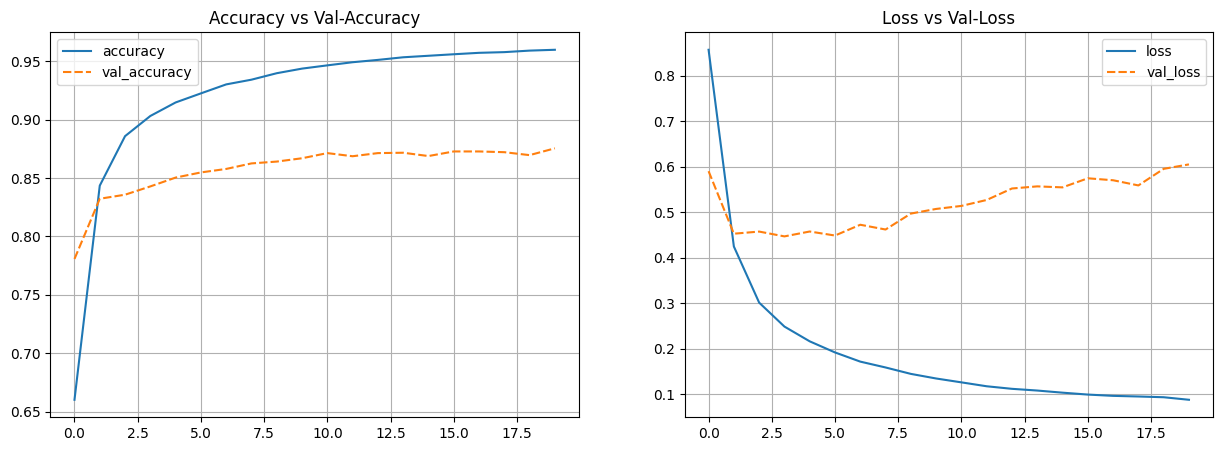

In [73]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [74]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [77]:
# Model Training using LSTM with Transfer Learning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(4, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=20, validation_data=(X_val, y_val_ohe))

Epoch 1/20
1786/1786 [==============================] - 60s 31ms/step - loss: 1.3557 - accuracy: 0.3246 - val_loss: 1.3452 - val_accuracy: 0.3458
Epoch 2/20
1786/1786 [==============================] - 55s 31ms/step - loss: 1.3384 - accuracy: 0.3580 - val_loss: 1.3333 - val_accuracy: 0.3589
Epoch 3/20
1786/1786 [==============================] - 57s 32ms/step - loss: 1.3323 - accuracy: 0.3636 - val_loss: 1.3271 - val_accuracy: 0.3678
Epoch 4/20
1786/1786 [==============================] - 64s 36ms/step - loss: 1.3263 - accuracy: 0.3711 - val_loss: 1.3411 - val_accuracy: 0.3499
Epoch 5/20
1786/1786 [==============================] - 63s 35ms/step - loss: 1.3261 - accuracy: 0.3697 - val_loss: 1.3313 - val_accuracy: 0.3683
Epoch 6/20
1786/1786 [==============================] - 62s 35ms/step - loss: 1.3178 - accuracy: 0.3790 - val_loss: 1.3221 - val_accuracy: 0.3708
Epoch 7/20
1786/1786 [==============================] - 76s 42ms/step - loss: 1.3134 - accuracy: 0.3821 - val_loss: 1.3165 -

c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

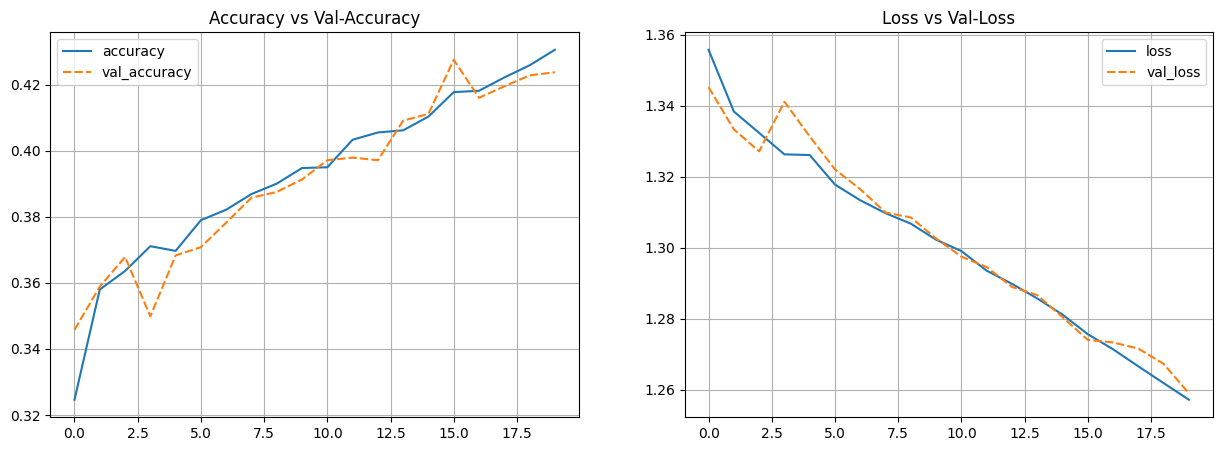

In [78]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [83]:
## Batch Size 128

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_3 = Sequential()
model_lstm_3.add(text_vectorization)
model_lstm_3.add(embedding)
model_lstm_3.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_3.add(Dropout(0.1))
model_lstm_3.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_3.add(Dropout(0.1))
model_lstm_3.add(Dense(4, activation='softmax'))

model_lstm_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

batch = 128
model_lstm_3_hist = model_lstm_3.fit(X_train, y_train_ohe, epochs=20, batch_size=batch, validation_data=(X_val, y_val_ohe))

Epoch 1/20
355/447 [======================>.......] - ETA: 10s - loss: 0.4913 - accuracy: 0.8232

c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

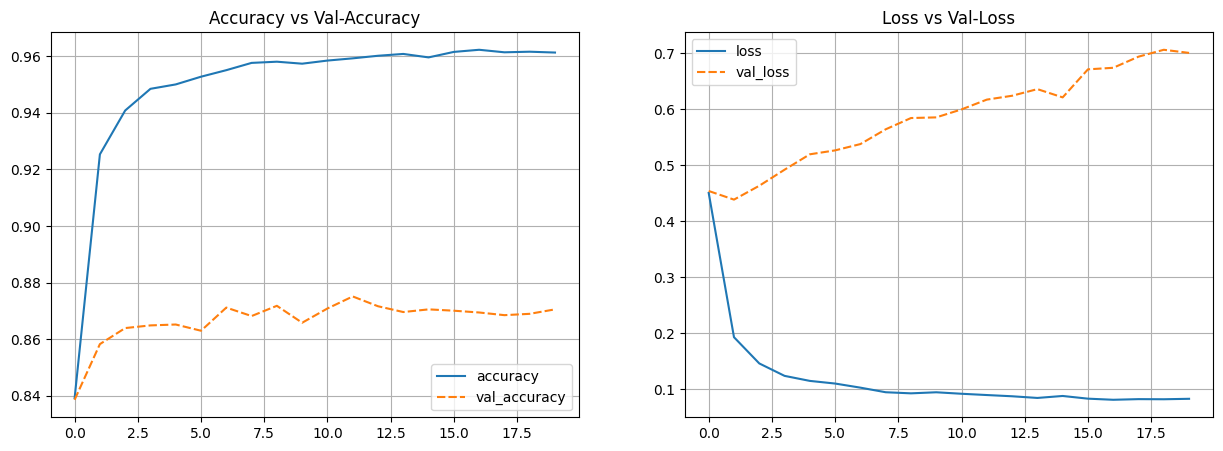

In [82]:
# Plot Training Results

model_lstm_3_hist_df = pd.DataFrame(model_lstm_3_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_3_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_3_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [ ]:
# Model Training using LSTM with Transfer Learning - 128 Batch

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_4 = Sequential()
model_lstm_4.add(hub_layer)
model_lstm_4.add(Reshape((128, 1)))
model_lstm_4.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_4.add(Dropout(0.1))
model_lstm_4.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_4.add(Dropout(0.1))
model_lstm_4.add(Dense(4, activation='softmax'))

model_lstm_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

batch = 128
model_lstm_4_hist = model_lstm_4.fit(X_train, y_train_ohe, epochs=20, batch_size=batch, validation_data=(X_val, y_val_ohe))